In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.join('..'))
from model import GreyboxModel

# load experiment parameters
with open(os.path.join('..', 'params.yaml'), 'r') as fd:
    params = yaml.safe_load(fd)

exptname = 'toy1'
trialname = 'demo'
mode = 'adaptive'

### Preparation

In [2]:
# load log
with np.load(os.path.join('..', 'out', trialname, mode, 'curve_tr.npz')) as data:
    L_tr = data['L_tr']
    L_va = data['L_va']

# load all data
with np.load(os.path.join('..', 'out', trialname, 'data_te.npz')) as data:
    x = data['x']
    y = data['y']
with np.load(os.path.join('..', 'out', trialname, 'data_tr.npz')) as data:
    x = np.concatenate((x, data['x']), axis=0)
    y = np.concatenate((y, data['y']), axis=0)

# load model
model = GreyboxModel(params['model'])
model.load_state_dict(torch.load(os.path.join('..', 'out', trialname, mode, 'model_te.pt')))
model.eval()

GreyboxModel(
  (net_fD): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

### Inspect learning curves

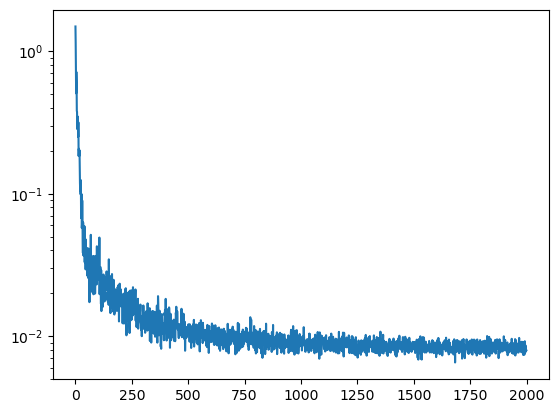

In [3]:
epochs_tr = np.array(list(range(0, L_tr.shape[0])))
# epochs_va = np.array(list(range(0, L_tr.shape[0], params['train']['valid_interval_epochs'])))

plt.plot(epochs_tr, np.mean(L_tr, axis=1))
# plt.plot(epochs_va, np.mean(L_va, axis=1))
plt.yscale('log')
# plt.legend(['train', 'validation'])
plt.show()

### Plot results for different [a,c]

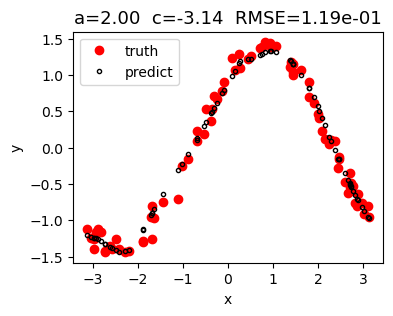

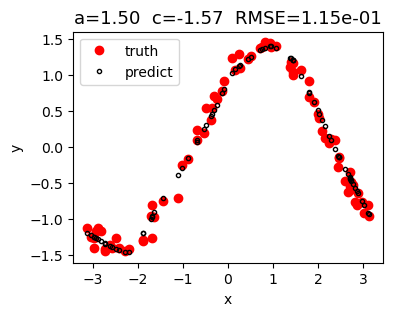

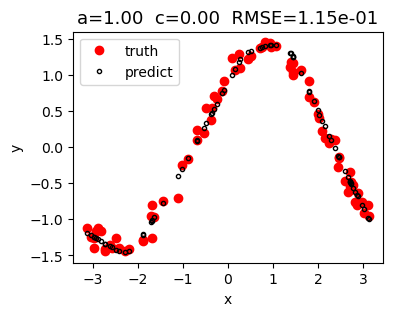

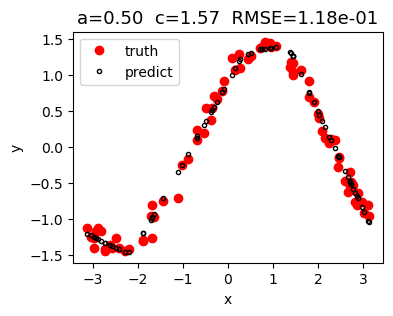

In [4]:
aa, cc = np.meshgrid(
    np.linspace(0.0, 2.0, 101),
    np.linspace(-3.14, 3.14, 101)
)

ij_to_plot = [
    (25,75),
    (50,50),
    (75,25),
    (0,100)
]

rmse = np.zeros_like(aa)
normT = np.zeros_like(aa)
normD = np.zeros_like(aa)
abs_dotTD = np.zeros_like(aa)
abs_diff_normTD = np.zeros_like(aa)
for i in range(aa.shape[0]):
    for j in range(aa.shape[1]):
        a = aa[i,j]
        c = cc[i,j]

        # prediction on test data
        with torch.no_grad():
            _thT = torch.tensor([a, c]).float().view(1,-1)
            _x = torch.tensor(x).view(-1,1).float()
            yh, _normT, _normD, _abs_dotTD, _abs_diff_normTD, _sq_c = model(_x, thT=_thT, return_all_R=True)
            yh = yh.view(-1,1).detach().numpy()

        # store results
        rmse[i,j] = np.sqrt(np.mean((yh-y)**2))
        normT[i,j] = _normT.item()
        normD[i,j] = _normD.item()
        abs_dotTD[i,j] = _abs_dotTD.item()
        abs_diff_normTD[i,j] = _abs_diff_normTD.item()

        # plot
        if (i,j) in ij_to_plot:
            plt.figure(figsize=(4,3))
            plt.plot(x, y, 'o', color='red')
            plt.plot(x, yh, '.', color='black', markerfacecolor='none')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('a=%0.2f  c=%0.2f  RMSE=%0.2e' % (a, c, rmse[i,j]), fontsize=13)
            plt.legend(('truth', 'predict'))
            plt.show()

test prediction RMSE (between $y$ and $\hat{y}$)


/tmp/ipykernel_1283/2834108836.py:4: RuntimeWarning: divide by zero encountered in log
  (np.log(abs_dotTD), r'$| \langle f_T, f_D \rangle |$ (log scale)'),


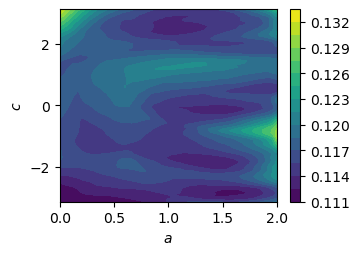

$\log \Vert f_D \Vert$


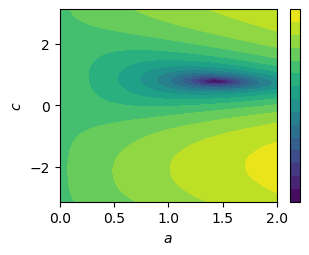

$| \langle f_T, f_D \rangle |$ (log scale)


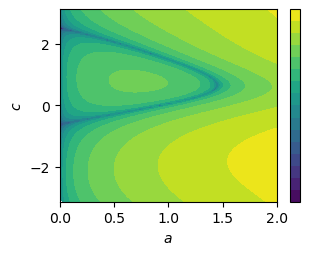

$| \Vert f_T \Vert - \Vert f_D \Vert |$ (log scale)


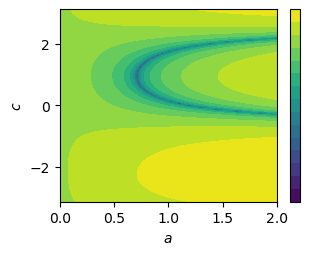

$| \langle f_T, f_D \rangle | + | \Vert f_T \Vert - \Vert \hat{y}-f_T \Vert |$ (log scale)


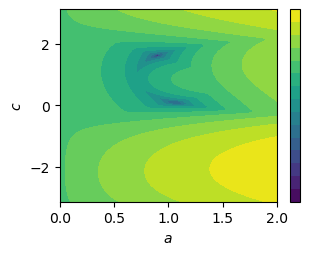

final R


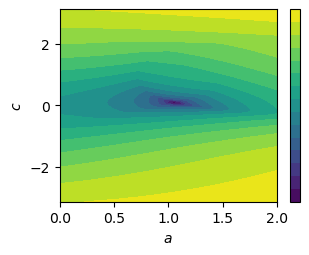

In [6]:
targets_and_names = [
    (rmse, r'test prediction RMSE (between $y$ and $\hat{y}$)'),
    (np.log(normD), r'$\log \Vert f_D \Vert$'),
    (np.log(abs_dotTD), r'$| \langle f_T, f_D \rangle |$ (log scale)'),
    (np.log(abs_diff_normTD), r'$| \Vert f_T \Vert - \Vert f_D \Vert |$ (log scale)'),
    (np.log(abs_dotTD + abs_diff_normTD), r'$| \langle f_T, f_D \rangle | + | \Vert f_T \Vert - \Vert \hat{y}-f_T \Vert |$ (log scale)'),
    (np.log(abs_dotTD + abs_diff_normTD + cc*cc), 'final R'),
]

for i,target_and_name in enumerate(targets_and_names):
    plt.figure(figsize=(3.5,2.5))
    plt.contourf(aa, cc, target_and_name[0], levels=16, cmap='viridis')
    # plt.plot(params['data']['a'], 0.0, 'x', color='magenta')
    cb = plt.colorbar()
    if i>0:
        cb.set_ticks([])
    plt.xlabel('$a$')
    plt.ylabel('$c$')
    # plt.title(target_and_name[1])
    print(target_and_name[1])
    plt.show()